# YNet - Dataset 5:

Data from Experiment (2), Mitochondria = Cit1-mCherry 

### Importing utilities:

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

#### Setting up variables

In [3]:
PATH = "../datasets/yeast_v5/"
data_path = Path(PATH)

In [4]:
CLASSES = ('WT', 'mfb1KO', 'mfb1KO_mmr1KO', 'mmr1KO', 'mmm1KO_230', 'num1_110' )
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = 200

In [ ]:
!ls ..

#### Calculating normalization statistics

In [5]:
stats_name = "yeast_v5_per_class.dict"
classes = Statistics.source_class(data_path)

train_val = zip(classes['train'], classes['val'])
# Xtest = zip(classes['test'])
 
main_stats = Statistics.per_class(train_val, save_name=stats_name)
# test_stats = Statistics.per_class(Xtest, save_name=stats_name)

working on: mfb1KO
working on: mfb1KO
working on: mfb1KO_mmr1KO
working on: mfb1KO_mmr1KO
working on: mmr1KO
working on: mmr1KO
working on: WT
working on: WT
working on: mmm1KO_230
working on: mmm1KO_230
working on: num1_110
working on: num1_110


In [6]:
for keys in main_stats.keys():
    print(f"{keys}: \t \t \t {main_stats[keys]}")

mfb1KO: 	 	 	 (array([0.01453, 0.00456]), array([0.00668, 0.00142]))
mfb1KO_mmr1KO: 	 	 	 (array([0.00789, 0.00471]), array([0.00072, 0.00152]))
mmr1KO: 	 	 	 (array([0.01455, 0.00484]), array([0.0067 , 0.00177]))
WT: 	 	 	 (array([0.01435, 0.00464]), array([0.00668, 0.0014 ]))
mmm1KO_230: 	 	 	 (array([0.02099, 0.00428]), array([0.00144, 0.00242]))
num1_110: 	 	 	 (array([0.02101, 0.005  ]), array([0.00147, 0.0022 ]))


In [ ]:
for keys in test_stats.keys():
    print(f"{keys}: \t \t \t {test_stats[keys]}")

## Defining datasets:

In [ ]:
def tfms_for_test(stats, sz):
    test_norm = Normalize(stats)
    test_denorm = Denormalize(stats)
    val_crop = CropType.NO
    test_tfms = image_gen(test_norm, test_denorm,sz, crop_type=val_crop)
    return test_tfms

In [7]:
def get_data(path: str, sz, bs):
    create, lbl2index = ImageClassifierData.prepare_from_path(path, val_name='val', bs=bs)
    main_stats_X = {lbl2index[key]: val for key, val in main_stats.items()}
#     test_stats_X= {lbl2index[key]: val for key, val in test_stats.items()}
    tfms = tfms_from_stats(main_stats_X, sz, aug_tfms=[RandomDihedral()], pad=sz//8)
#     test_tfms = tfms_for_test(test_stats_X,sz)
#     tfms += (test_tfms, )
    print('\n class to index mapping:\n',lbl2index)
    return create(tfms)


In [8]:
data = get_data(PATH,SIZE, BATCH_SIZE)

../datasets/yeast_v5/ {}
../datasets/yeast_v5/ {'WT': 0, 'mfb1KO': 1, 'mfb1KO_mmr1KO': 2, 'mmm1KO_230': 3, 'mmr1KO': 4, 'num1_110': 5}

 class to index mapping:
 {'WT': 0, 'mfb1KO': 1, 'mfb1KO_mmr1KO': 2, 'mmm1KO_230': 3, 'mmr1KO': 4, 'num1_110': 5}


In [9]:
x, y = next(iter(data.trn_dl))

### Inspect loaded data:

In [ ]:
# specify which image-index
idx = 60

# loading it from GPU to CPU
xx = x[idx].cpu().numpy().copy()
yy = y[idx]
# showing the image
#
#sp.axis('Off')
#sp.set_title("Norm", fontsize=11)
figure, _ ,_ = tiff.imshow(np.sum(xx, axis=0))
figure.set_size_inches(6,6)
figure.add_subplot(111)

figure2, _, _ = tiff.imshow(np.sum(data.trn_ds.denorm(xx,yy).squeeze() * 65536, axis=2))
figure2.set_size_inches(6,6)


# Training setup

In [10]:
torch.cuda.is_available()

True

## ResNet_with_Batchnorm

In [11]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [12]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [13]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [14]:
wd=1e-5

In [15]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 6), data)

In [16]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 2, 200, 200]),
                           ('output_shape', [-1, 10, 200, 200]),
                           ('trainable', True),
                           ('nb_params', 510)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 100, 100]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', 3600)])),
             ('ResnetLayer-5',
     

In [17]:
%time learn.fit(1e-2, 8, cycle_len=1, wds=wd)

EPOCH 0 ---------------------------------------- STEP 0   
mean: [21.71429 21.09524  4.90476 14.19048 30.2381   5.2381 ]
stdev: [8.45798 5.70634 2.99054 3.5135  5.68125 2.54305]

[WT]:  0.0%
[mfb1KO]: 50.0%
[mfb1KO_mmr1KO]:  0.0%
[mmm1KO_230]: 94.29%
[mmr1KO]: 50.0%
[num1_110]:  0.0%
epoch      trn_loss   val_loss   accuracy   
    0      10.702352  4.518074   0.326984  
EPOCH 1 ---------------------------------------- STEP 1   
mean: [21.7619  21.14286  4.90476 14.14286 30.19048  5.19048]
stdev: [5.07941 4.63204 2.48624 4.22336 4.46808 3.4726 ]

[WT]:  0.0%
[mfb1KO]: 50.0%
[mfb1KO_mmr1KO]: 57.14%
[mmm1KO_230]: 91.43%
[mmr1KO]: 50.0%
[num1_110]:  0.0%
    1      6.234604   1.771251   0.387302  
EPOCH 2 ---------------------------------------- STEP 2   
mean: [21.71429 21.09524  4.90476 14.09524 30.28571  5.28571]
stdev: [4.60996 4.04622 3.30807 5.01336 5.9132  2.76273]

[WT]: 40.0%
[mfb1KO]:  0.0%
[mfb1KO_mmr1KO]: 34.29%
[mmm1KO_230]: 100.0%
[mmr1KO]: 50.0%
[num1_110]:  0.0%
    2     

[array([1.04101]), 0.466666669315762]

In [18]:
# at very little overfitting we have 43% accuracy
%time learn.fit(1e-2, 8, wds=wd, cycle_len=10, use_clr=(20,8, 0.95, 0.85))

EPOCH 0 ---------------------------------------- STEP 8   
mean: [21.52381 21.19048  4.85714 14.2381  30.09524  5.19048]
stdev: [5.72063 4.56299 2.69542 5.66447 5.35328 3.4726 ]

[WT]: 48.57%
[mfb1KO]: 1.429%
[mfb1KO_mmr1KO]: 8.571%
[mmm1KO_230]: 85.71%
[mmr1KO]: 50.0%
[num1_110]: 17.14%
epoch      trn_loss   val_loss   accuracy   
    0      1.201951   2.147648   0.346032  
EPOCH 1 ---------------------------------------- STEP 9   
mean: [21.61905 21.09524  5.      14.38095 30.04762  5.19048]
stdev: [4.6545  4.55553 2.46885 3.49797 5.89977 2.68362]

[WT]: 48.57%
[mfb1KO]: 10.0%
[mfb1KO_mmr1KO]: 25.71%
[mmm1KO_230]: 28.57%
[mmr1KO]: 45.71%
[num1_110]: 71.43%
    1      1.14884    1.661075   0.371429  
EPOCH 2 ---------------------------------------- STEP 10  
mean: [21.57143 21.38095  4.85714 14.14286 30.2381   5.2381 ]
stdev: [6.42593 6.00378 3.16658 3.84566 5.32653 2.4281 ]

[WT]:  0.0%
[mfb1KO]: 51.43%
[mfb1KO_mmr1KO]: 48.57%
[mmm1KO_230]: 91.43%
[mmr1KO]: 50.0%
[num1_110]: 2.857%
 

[WT]: 67.14%
[mfb1KO]: 51.43%
[mfb1KO_mmr1KO]: 80.0%
[mmm1KO_230]: 94.29%
[mmr1KO]: 58.57%
[num1_110]: 74.29%
    24     0.880847   0.739447   0.669841  
EPOCH 25 ---------------------------------------- STEP 33  
mean: [21.66667 21.14286  4.90476 14.28571 30.09524  5.09524]
stdev: [5.71825 4.43241 3.30807 4.54756 6.45058 2.7413 ]

[WT]: 51.43%
[mfb1KO]: 48.57%
[mfb1KO_mmr1KO]: 97.14%
[mmm1KO_230]: 100.0%
[mmr1KO]: 61.43%
[num1_110]: 31.43%
    25     0.833407   0.887069   0.612698  
EPOCH 26 ---------------------------------------- STEP 34  
mean: [21.7619  21.09524  4.95238 14.28571 30.2381   5.19048]
stdev: [4.19642 5.06063 3.40135 4.9966  6.69687 3.06468]

[WT]: 70.0%
[mfb1KO]: 44.29%
[mfb1KO_mmr1KO]: 97.14%
[mmm1KO_230]: 65.71%
[mmr1KO]: 64.29%
[num1_110]: 82.86%
    26     0.793759   0.676098   0.669841  
EPOCH 27 ---------------------------------------- STEP 35  
mean: [21.57143 21.09524  4.85714 14.2381  30.14286  5.19048]
stdev: [4.69621 4.1393  2.91606 5.48509 5.11101 2.06142

[WT]: 71.43%
[mfb1KO]: 85.71%
[mfb1KO_mmr1KO]: 91.43%
[mmm1KO_230]: 94.29%
[mmr1KO]: 74.29%
[num1_110]: 100.0%
    73     0.457281   0.42501    0.831746  
EPOCH 74 ---------------------------------------- STEP 82  
mean: [21.57143 21.14286  5.      14.19048 30.14286  5.14286]
stdev: [5.10435 4.1666  3.3665  4.57341 5.18501 1.72615]

[WT]: 80.0%
[mfb1KO]: 80.0%
[mfb1KO_mmr1KO]: 97.14%
[mmm1KO_230]: 94.29%
[mmr1KO]: 77.14%
[num1_110]: 71.43%
    74     0.441104   0.432566   0.819048  
EPOCH 75 ---------------------------------------- STEP 83  
mean: [21.66667 21.09524  5.      14.14286 30.14286  5.28571]
stdev: [4.38974 4.96564 2.46885 4.01528 4.61143 2.60298]

[WT]: 94.29%
[mfb1KO]: 88.57%
[mfb1KO_mmr1KO]: 91.43%
[mmm1KO_230]: 100.0%
[mmr1KO]: 72.86%
[num1_110]: 88.57%
    75     0.409947   0.331262   0.879365  
EPOCH 76 ---------------------------------------- STEP 84  
mean: [21.61905 21.04762  4.90476 14.14286 30.09524  5.09524]
stdev: [4.86461 4.90361 2.38856 3.96756 5.35328 2.97457

[array([0.58028]), 0.7873015890045771]

In [19]:
%time learn.fit(1e-3, 2, wds=wd, cycle_len=20, use_clr=(20,8, 0.95, 0.85))

EPOCH 0 ---------------------------------------- STEP 88   
mean: [21.66667 21.2381   4.95238 14.19048 30.33333  5.19048]
stdev: [6.51981 3.96298 2.80266 3.40335 7.38295 2.12959]

[WT]: 87.14%
[mfb1KO]: 81.43%
[mfb1KO_mmr1KO]: 94.29%
[mmm1KO_230]: 100.0%
[mmr1KO]: 77.14%
[num1_110]: 94.29%
epoch      trn_loss   val_loss   accuracy   
    0      0.284225   0.31505    0.866667  
EPOCH 1 ---------------------------------------- STEP 89   
mean: [21.61905 21.09524  4.90476 14.38095 30.09524  5.19048]
stdev: [4.19156 5.9913  2.87692 5.85927 6.72525 3.24579]

[WT]: 81.43%
[mfb1KO]: 91.43%
[mfb1KO_mmr1KO]: 85.71%
[mmm1KO_230]: 97.14%
[mmr1KO]: 71.43%
[num1_110]: 94.29%
    1      0.28546    0.362473   0.850794  
EPOCH 2 ---------------------------------------- STEP 90   
mean: [21.57143 21.19048  4.90476 14.09524 30.09524  5.19048]
stdev: [5.27863 5.56022 2.068   5.78096 6.74646 3.21631]

[WT]: 82.86%
[mfb1KO]: 87.14%
[mfb1KO_mmr1KO]: 88.57%
[mmm1KO_230]: 100.0%
[mmr1KO]: 81.43%
[num1_110]: 9

[WT]: 80.0%
[mfb1KO]: 92.86%
[mfb1KO_mmr1KO]: 85.71%
[mmm1KO_230]: 94.29%
[mmr1KO]: 71.43%
[num1_110]: 100.0%
    24     0.261067   0.366288   0.853968  
EPOCH 25 ---------------------------------------- STEP 113 
mean: [21.57143 21.04762  4.95238 14.28571 30.19048  5.14286]
stdev: [5.2696  5.99584 2.47802 4.87113 4.18181 2.16654]

[WT]: 75.71%
[mfb1KO]: 88.57%
[mfb1KO_mmr1KO]: 91.43%
[mmm1KO_230]: 94.29%
[mmr1KO]: 91.43%
[num1_110]: 94.29%
    25     0.262856   0.351251   0.879365  
EPOCH 26 ---------------------------------------- STEP 114 
mean: [21.7619  21.09524  4.90476 14.19048 30.14286  5.28571]
stdev: [6.48739 5.78096 3.24998 4.22711 4.69332 3.32584]

[WT]: 75.71%
[mfb1KO]: 87.14%
[mfb1KO_mmr1KO]: 91.43%
[mmm1KO_230]: 94.29%
[mmr1KO]: 82.86%
[num1_110]: 91.43%
    26     0.253982   0.347418   0.853968  
EPOCH 27 ---------------------------------------- STEP 115 
mean: [21.61905 21.       4.95238 14.2381  30.47619  5.09524]
stdev: [5.24156 3.94003 3.7094  3.92677 6.32169 2.3483

[array([0.27405]), 0.8825396776199341]

In [22]:
%time learn.fit(1e-3, 2, wds=wd, cycle_len=20, use_clr=(20,8, 0.95, 0.85), best_save_name='YNet_Res_v5_redo_1')

EPOCH 0 ---------------------------------------- STEP 128  
mean: [21.66667 21.14286  4.80952 14.2381  30.04762  5.2381 ]
stdev: [5.67646 4.54905 2.61168 4.29734 5.4465  2.34835]

[WT]: 82.86%
[mfb1KO]: 77.14%
[mfb1KO_mmr1KO]: 88.57%
[mmm1KO_230]: 94.29%
[mmr1KO]: 92.86%
[num1_110]: 94.29%
epoch      trn_loss   val_loss   accuracy   
    0      0.227348   0.373071   0.869841  
EPOCH 1 ---------------------------------------- STEP 129  
mean: [21.7619  21.2381   4.85714 14.09524 30.04762  5.14286]
stdev: [5.40639 6.15595 2.43556 4.30841 4.97112 2.89968]

[WT]: 84.29%
[mfb1KO]: 85.71%
[mfb1KO_mmr1KO]: 88.57%
[mmm1KO_230]: 94.29%
[mmr1KO]: 92.86%
[num1_110]: 100.0%
input an addition to the save path or leave blank to abort
prompt: 1
    1      0.234617   0.323821   0.898413  
EPOCH 2 ---------------------------------------- STEP 130  
mean: [21.7619  21.14286  4.90476 14.38095 30.       5.14286]
stdev: [5.12607 4.7937  3.05357 4.11126 4.6291  2.79942]

[WT]: 75.71%
[mfb1KO]: 100.0%
[mfb1K

[WT]: 90.0%
[mfb1KO]: 75.71%
[mfb1KO_mmr1KO]: 88.57%
[mmm1KO_230]: 94.29%
[mmr1KO]: 85.71%
[num1_110]: 94.29%
    23     0.230904   0.382867   0.866667  
EPOCH 24 ---------------------------------------- STEP 152 
mean: [21.80952 21.04762  4.85714 14.09524 30.09524  5.19048]
stdev: [5.32397 5.0754  2.84999 4.6075  4.50296 2.66582]

[WT]: 80.0%
[mfb1KO]: 98.57%
[mfb1KO_mmr1KO]: 88.57%
[mmm1KO_230]: 94.29%
[mmr1KO]: 82.86%
[num1_110]: 100.0%
    24     0.220178   0.326805   0.895238  
EPOCH 25 ---------------------------------------- STEP 153 
mean: [21.85714 21.28571  4.95238 14.14286 30.       5.2381 ]
stdev: [5.40093 4.9775  2.59076 4.02712 7.23747 3.19083]

[WT]: 74.29%
[mfb1KO]: 84.29%
[mfb1KO_mmr1KO]: 91.43%
[mmm1KO_230]: 94.29%
[mmr1KO]: 90.0%
[num1_110]: 94.29%
    25     0.21793    0.371198   0.863492  
EPOCH 26 ---------------------------------------- STEP 154 
mean: [21.71429 21.04762  4.90476 14.04762 30.28571  5.2381 ]
stdev: [4.84171 5.8836  2.20183 3.7982  6.04856 2.68868]

[array([0.30751]), 0.876190477893466]

### Show loss over time

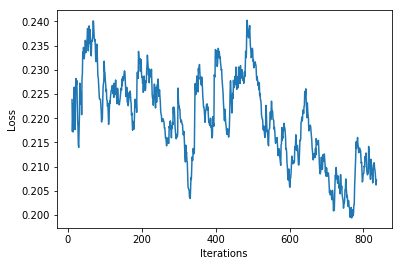

In [23]:
f = plt.figure()
x = learn.sched.plot_loss()
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.show()

## Analysis

### ...after training 

In [ ]:
## Load model:
learn.load('Objective_A_Resnet_per_class_2')

In [ ]:
%time learn.fit(1e-10, 1, wds=wd, cycle_len=1)

In [ ]:
log_preds, y = learn.TTA() # run predictions with TTA

### Confusion matrix

In [ ]:
# Plot confusion matrix 
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
cm = confusion_matrix(preds,y)
plot_confusion_matrix(cm, data.classes)

### Analyse images 

#### Show random correct/incorrectly classified images:

In [ ]:
log_preds_mean = np.mean(log_preds, axis=0) # averages predictions on original + 4 TTA images
preds = np.argmax(log_preds_mean, axis=1) # converts into 0 or 1

In [ ]:
# probs = np.exp(log_preds_mean[:,0]) # prediction(WT)
probs = np.exp(log_preds_mean) # predictions

In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [ ]:
def plots(ims, channel, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=11)
        if channel is not None: plt.imshow(ims[i,channel,:,:]) 
        else: plt.imshow(np.sum(ims, axis=1)[i,:,:])

In [ ]:
def plot_val_with_title_from_ds_no_denorm(idxs, title, channel=None):
    
    imgs = np.stack(data.val_ds[x][0] for x in idxs) # get images by idx
    corr_lbl = np.stack(data.val_ds[x][1] for x in idxs) # get correct label from data.val_ds by idx
    pred_lbl = np.stack(preds[x] for x in idxs) # get predicted label from preds by idx
    p_max = [np.amax(probs[x,:]) for x in idxs] # get highes probability from probs by idx
    
    title_fin = [f"true = {corr_lbl[x]}\n predicted: {pred_lbl[x]}\n  p = {p_max[x]}" for x in corr_lbl]
    print(title)
    
    return plots(imgs, channel, rows=1, titles=title_fin, figsize=(16,8))

### Plot images according to predictions

In [ ]:
# load from ds - not denormalized! 
plot_val_with_title_from_ds_no_denorm(rand_by_correct(True), "Correctly classified")
#optionally pass channel arg. to select single channel

In [ ]:
plot_val_with_title_from_ds_no_denorm(rand_by_correct(False), "Incorrectly classified")

#### Show most correct/incorrectly classified images per class:

In [ ]:
def most_by_mask(mask, y, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[:,y][idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), y, mult)

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(0, True), "Most correctly classified WT")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(0, False), "Most incorrectly classified WT") # logic?

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(1, True), "Most correctly classified mfb1KO") 

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(1, False), "Most incorrectly classified mfb1KO")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(2, True), "Most correctly classified mfb1KO-mmr1KO")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(3, True), "Most correctly classified mmr1KO")

In [ ]:
# etc.

#### Show (most) uncertain images

In [ ]:
most_uncertain = t = np.argsort(np.amax(probs, axis = 1))[:6] # get best "guess" per image and list the least confident ones
plot_val_with_title_from_ds_no_denorm(most_uncertain, "Most uncertain predictions")

# DOES THE MODEL GENERALIZE?????

In [ ]:
def get_test_data(path: str, sz, bs):
    create, lbl2index = ImageClassifierData.prepare_from_path(path, val_name='val', test_name='test', test_with_labels=True, bs=bs)
    main_stats_X = {lbl2index[key]: val for key, val in main_stats.items()}
    test_stats_X= {lbl2index[key]: val for key, val in test_stats.items()}
    tfms = tfms_from_stats(main_stats_X, sz, aug_tfms=[RandomDihedral()], pad=sz//8) #even without transformations and padding -> failure
    test_tfms = tfms_for_test(test_stats_X,sz)
    tfms += (tfms[0], )
    print('\n class to index mapping:\n',lbl2index)
    return create(tfms)

In [ ]:
test_data = get_test_data(PATH,SIZE, BATCH_SIZE)

In [ ]:
test_learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 4), test_data)

In [ ]:
test_learn.load('Objective_A_Resnet_per_class_2')

In [ ]:
test_learn.warm_up(1e-14)

In [ ]:
test_log_preds, targs = test_learn.predict_with_targs(is_test=True)
testprobs = np.exp(test_log_preds)
preds = np.argmax(testprobs, axis=1)
print(preds)
print(targs)

In [ ]:
# Print Accuracy
print(f"accuracy: [{sum(preds == targs) / 70:4.4}]")

In [ ]:
test_log_preds

### Troubleshooting:

In [ ]:
test_x , test_y = next(iter(test_data.test_dl))

In [ ]:
# specify which image-index
idx = 2

# loading it from GPU to CPU
test_xx = test_x[idx].cpu().numpy().copy()
test_yy = test_y[idx]

figure, _ ,_ = tiff.imshow(np.sum(test_xx, axis=0))
figure.set_size_inches(6,6)
figure.add_subplot(111)

figure2, _, _ = tiff.imshow(np.sum(xx, axis=0))
figure2.set_size_inches(6,6)


## Caclulating normalization statistics separately

In [ ]:
for keys in main_stats.keys():
    print(f"{keys}: \t \t \t {main_stats[keys]}")

In [ ]:
for keys in test_stats.keys():
    print(f"{keys}: \t \t \t {test_stats[keys]}")

In [ ]:
## Load model:
learn.load('Objective_A_Resnet_per_class_2')

In [ ]:
%time learn.fit(1e-10, 1, wds=wd, cycle_len=1)

In [ ]:
test_log_preds, targs = learn.predict_with_targs(is_test=True)
testprobs = np.exp(test_log_preds)
preds = np.argmax(testprobs, axis=1)
print(preds)
print(targs)

In [ ]:
# Print Accuracy
print(f"accuracy: [{sum(preds == targs) / 140:4.4}]")

In [ ]:
test_log_preds